In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import os
import glob
import PIL
import pandas as pd
import random
import matplotlib.pyplot as plt

设置随机种子：确保在深度学习任务中的随机性是可重现的。随机性在深度学习中很常见，例如，权重初始化、数据批次的随机抽样、Dropout 等操作都包含了随机性，而设置随机种子可以使这些随机操作在不同运行中产生相同的结果，从而方便调试和比较不同模型的性能。

In [2]:
bath_size = 32
device = 'cuda'
torch.cuda.manual_seed_all(1234)

鲁棒性：系统在面对不同类型和程度的变化或挑战时能够保持其预期功能或性能。
transforms.RandomResizedCrop(224)：在原始图像中随机选择一个矩形区域（裁剪框），这个区域的大小和位置都是随机的。然后，将选定的区域调整为指定的大小（在这里是 224x224 像素）。通常使用双线性插值来进行图像的重新采样，以确保调整后的图像看起来平滑。提高鲁棒性。
transforms.RandomHorizontalFlip()：帮助模型学习不同视角下的物体，提高模型的泛化能力。

In [3]:
train_dir = './dataset/train/train'
test_dir = './dataset/test/test'

# glob.glob是用来查找符合特定规则的文件路径名的，跟使用正则表达式的方法很类似
train_list = glob.glob(os.path.join(train_dir, '*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
])
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
])


In [4]:
class MyDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = PIL.Image.open(img_path)
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'train\\cat':
            label = 0
        elif label == 'train\\dog':
            label = 1
        if self.transform:
            img = self.transform(img)
        return img, label

In [5]:
train_data = MyDataset(train_list, transform=train_transforms)
test_data = MyDataset(test_list, transform=test_transforms)

In [6]:
train_loader = DataLoader(dataset=train_data, batch_size=bath_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=bath_size, shuffle=False)


## 构建CNN模型
### 卷积层（Convolutional Layer）：
卷积核就像一个小窗口在图像上滑动，一次只看一小部分图像（比如5x5像素），然后通过一些数学运算（卷积操作）来检测图像中的特征，比如边缘、纹理等。这一层的目标是捕捉图像的局部信息，通常是一个正方形的矩阵。可以根据希望卷积核捕获的特征尺寸来选择合适的大小。较小的卷积核通常用于捕获局部特征，而较大的卷积核可以捕获更大范围的特征。
归一化：nn.BatchNorm2d(16) 表示在神经网络中应用批量归一化层，作用于一个具有 16 个输出通道（特征图）的卷积层或线性层的输出。批量归一化通常紧跟在卷积层或全连接层后面，以确保网络的稳定性和训练效果。
激活函数：nn.ReLU(inplace=True) 表示在神经网络中应用 ReLU 激活函数，作用于卷积层或线性层的输出。ReLU 激活函数可以增加网络的非线性特性，从而提高网络的表达能力。将所有负数输入变为零，保持正数输入不变。
### 池化层（Pooling Layer）：
这一层的任务是缩小图像的尺寸，减少计算量，并且保留最重要的信息。通常，池化层会在卷积层的输出上滑动一个小窗口，然后选择窗口中的最大值（最大池化）或者平均值（平均池化）作为新图像的一部分。这有助于降低图像的维度。
### 全连接层（Fully Connected Layer）
这一层是CNN的输出层，它将前面的卷积和池化层提取的特征连接在一起，并将它们送入一个神经网络中，用于最终的分类或回归任务。这一层通常包含多个神经元，每个神经元与前一层的所有神经元相连接，因此称为全连接。
丢弃层（Dropout Layer）：nn.Dropout 用于在训练过程中随机丢弃一部分神经元的输出，以减少过拟合的风险。参数 0.5 表示丢弃概率为 50%，即每个神经元在前向传播过程中都有 50% 的概率被丢弃。这有助于提高模型的泛化能力。

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # 调用父类的初始化函数
        # 卷积+池化层
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=0), # 3*224*224 -> 16*224*224, stride=2保证卷积核每次移动一个像素, padding=0表示的是在图像周围补0个数,kernel_size=3表示卷积核大小为3*3
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2) # 16*224*224 -> 16*112*112, kernel_size=2表示池化窗口大小为2*2
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=0), # 16*112*112 -> 32*112*112
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2) # 32*112*112 -> 32*56*56
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        # 全连接层
        self.fc1 = nn.Linear(3*3*64, 10) # 3*3*64表示输入的特征数，10表示输出的特征数
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2) # 映射到 0/1 两种分类
        self.relu = nn.ReLU()

    # 调用之前定义的层
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(out.size(0),-1) # 从多维向量变成一维向量
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [8]:
model = CNN().to(device)
model.train()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10,

## 逻辑回归
调整CNN中卷积核权重和偏差，全连接层权重和偏差等

In [9]:
optimizer = optim.Adam(params=model.parameters(),lr=0.001)

## 定义损失函数
交叉熵损失函数

In [10]:
criterion = nn.CrossEntropyLoss()

## 训练
前向传播: 通过输入数据和模型，计算出预测值
反向传播: 通过计算损失函数，计算出梯度
为什么要梯度清零: 因为pytorch中梯度是累加的，所以每次反向传播之前都要把梯度清零

In [11]:
epoch = 10
for epoch in range(epoch):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad() # 梯度清零
        loss.backward() # 反向传播
        optimizer.step() # 更新参数

        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    print('Epoch:{}, accuracy:{}, loss:{}'.format(epoch+1,epoch_accuracy,epoch_loss))

Epoch:1, accuracy:0.6611249446868896, loss:0.6160609722137451
Epoch:2, accuracy:0.7052830457687378, loss:0.5653451681137085
Epoch:3, accuracy:0.7285003066062927, loss:0.5339006781578064
Epoch:4, accuracy:0.7440050840377808, loss:0.5076626539230347
Epoch:5, accuracy:0.752117395401001, loss:0.4982065260410309
Epoch:6, accuracy:0.760509192943573, loss:0.48245126008987427
Epoch:7, accuracy:0.769341766834259, loss:0.4712230861186981
Epoch:8, accuracy:0.7723380327224731, loss:0.4637530446052551
Epoch:9, accuracy:0.773377001285553, loss:0.4592275619506836
Epoch:10, accuracy:0.7797712087631226, loss:0.4546048045158386


In [12]:
dog_prob = []
model.eval() # 模型转换为评估模式
with torch.no_grad(): # 在其内部的代码块中禁用梯度计算,在代码块执行结束后梯度计算会重新启用
    for data, idx in test_loader:
        idx = map(lambda x: x.split('\\')[-1], idx)
        data = data.to(device)
        pred = model(data)
        pred_list = F.softmax(pred,dim=1)[:, 1].tolist() # 将模型的输出转化为一个概率分布，确保所有类别的概率之和等于1。也可以用sigmoid。
        dog_prob += list(zip(list(idx), pred_list))


dog_prob.sort(key = lambda x : int(x[0]))

In [13]:
idx = list(map(lambda x: x[0], dog_prob))
prob = list(map(lambda x: x[1], dog_prob))
submission = pd.DataFrame({'id':idx, 'label':prob})
submission


,id,label
0,1,0.915321
1,2,0.913421
2,3,0.894298
3,4,0.995251
4,5,0.053160
...,...,...
12495,12496,0.157272
12496,12497,0.056771
12497,12498,0.537984
12498,12499,0.982604


In [14]:
submission.to_csv('result.csv', index = False)

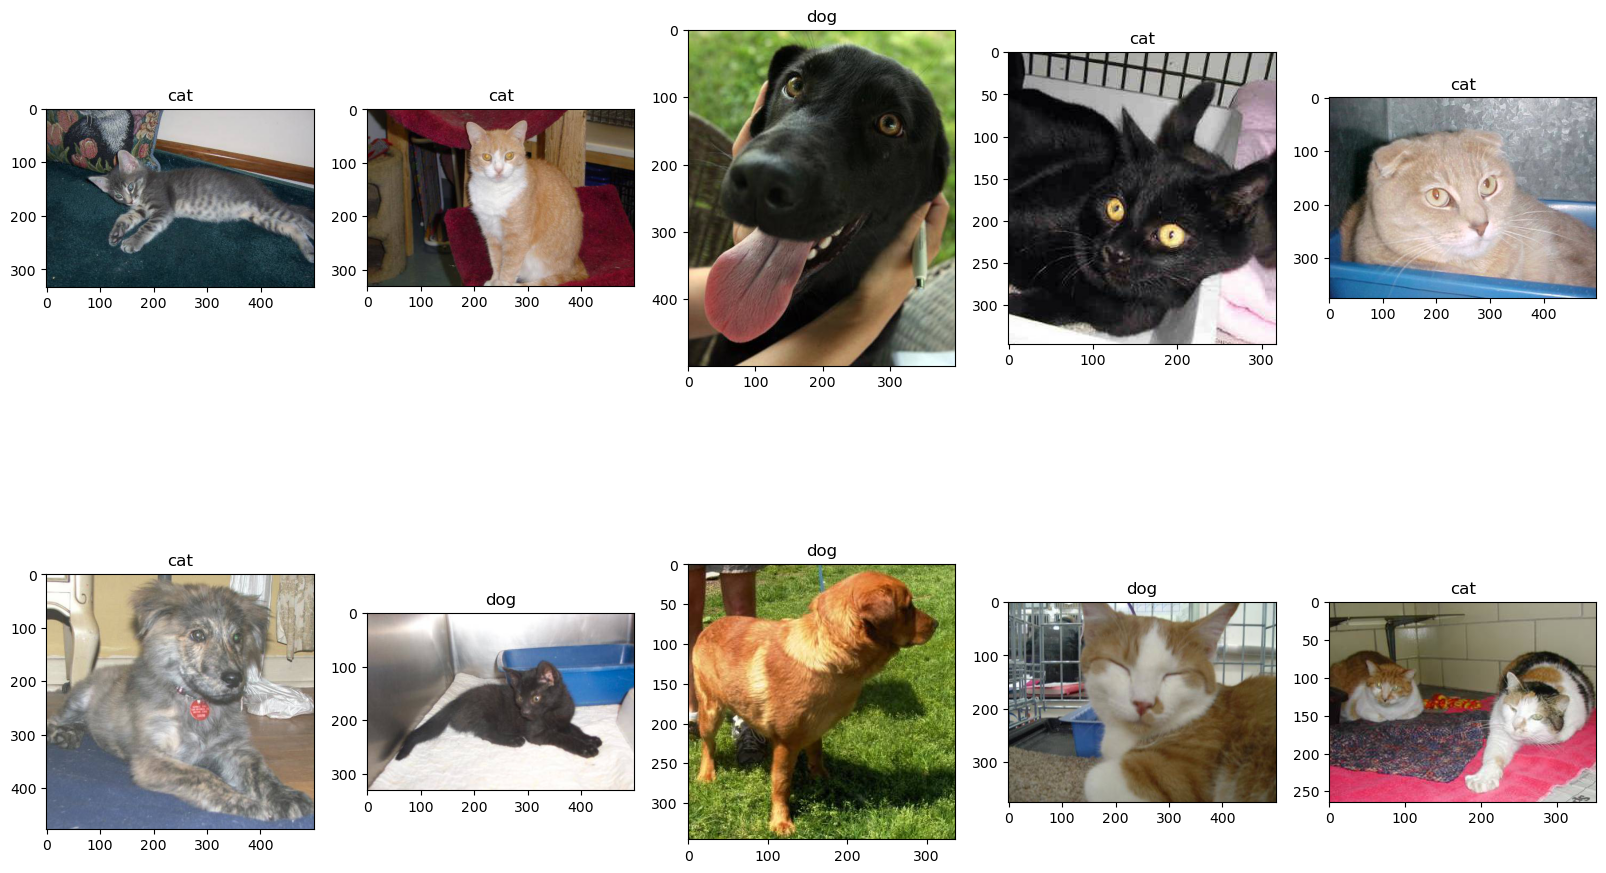

In [15]:
fig, axis = plt.subplots(2, 5, figsize=(20,12), facecolor='w')

for ax in axis.ravel():
    i = random.choice(submission['id'].values)
    label = submission.loc[submission['id']==i, 'label'].values[0]
    if label > 0.5:
        label = 'dog'
    else:
        label = 'cat'
    img_path = os.path.join(test_dir, '{}.jpg'.format(i))
    img = PIL.Image.open(img_path)
    ax.set_title(label)
    ax.imshow(img)

